# Time-Domain simulations


We introduce time-domain simulations, which are based on GRANAD's default master equation

$$\dot{\rho}(t) = -i [H[t,\rho(t)], \rho] + \mathcal{D}[t, \rho]$$

The non-linear Hamiltonian is given by

$$H[t,\rho(t)] = h^{0} + \vec{E} \vec{P} + C(\rho(t) - \rho^{0})$$

where 

1. $h^{0}$ is the unperturbed or bare Hamiltonian constructed from localized orbitals.
2. $\vec{P}$ is the polarization operator depending on space $\vec{r}$ and transition dipole moments $\vec{d}$, leading to an interatomic potential $\vec{E}\vec{r}$ and an intra-atomic potential $\vec{E} \vec{d}$.
3. $\rho^{0}$ is the stationary density matrix of the system's ground state, and $C$ is the Coulomb matrix (a subset of two-body matrix elements).

This expression is the dipole-gauge expression for the Hamiltonian including an external electric field $\vec{E}$.

## Observables

You can compute multiple observables in one simulation run

In [1]:
from granad import MaterialCatalog, Hexagon, Pulse
flake = MaterialCatalog.get("graphene").cut_flake( Hexagon(10) )

pulse = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=2.3, peak=5, fwhm=2
)

operators = [flake.dipole_operator, flake.velocity_operator]

result = flake.master_equation(
    relaxation_rate = 1/10,
    illumination = pulse,
    expectation_values = operators,
    end_time = 40,
     )

RHS compiled
RHS compiled


49.992928864375614 %


100.0 %


The result object stores this info. Operators are concatenated in the order you passed them in.

In [2]:
print(len(result.output))
print(result.output[0].shape)

1
(7072, 6)


The induced dipole moment at timestep 10 is given by

In [3]:
print(result.output[0][10,:3])

[5.19272438e-13+0.j 7.16792153e-14+0.j 0.00000000e+00+0.j]


Induced current at timestep 10

In [4]:
print(result.output[0][10,3:])

[ 1.41707761e-11-5.33512817e-15j -4.31137844e-15+8.93268929e-15j
  0.00000000e+00+0.00000000e+00j]


We can access the Fourier transform as

In [5]:
omega_min, omega_max = 0, 5
omegas, pulse_omega = result.ft_illumination( omega_min = omega_min, omega_max = omega_max )
output_omega = result.ft_output( omega_min = omega_min, omega_max = omega_max )[0]

From the classical continuity equation, we have

$$\dot{\rho}(x, t) = -\nabla \vec{j}(x, t) = \nabla \dot{\vec{p}}(t) \implies \dot{\vec{p}}(x,t) = \vec{j}(x,t) \implies \omega \vec{p}(x, \omega) = \vec{j}(x, \omega)$$

Or, in its integrated form

$$\int dx \dot{\vec{p}}(x,t) = \dot{\vec{p}}(t) = \int dx \vec{j}(x,t) =  \vec{j}(t)

Where $\vec{j}$ and $\vec{p}$ are the total current and dipole moment respectively. As classical quantities are given by ensemble averages of quantum operators, we can
obtain these quantities directly from the time-domain simulations. The (integrated) continuity equation above can be verified as follows

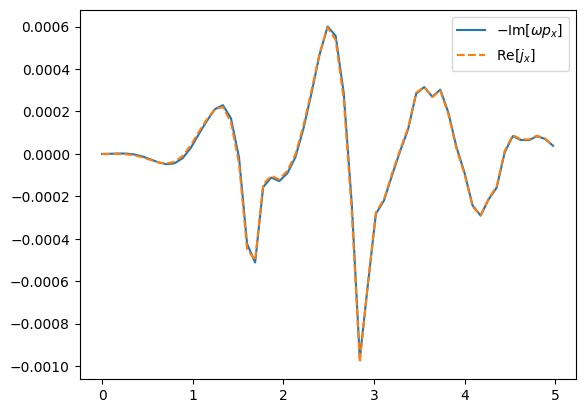

In [6]:
import matplotlib.pyplot as plt
p = -(omegas * output_omega[:,0]).imag
j = output_omega[:,3].real
plt.plot(omegas, p, label = r'$- \text{Im}[\omega p_x]$')
plt.plot(omegas, j, '--', label = r'$\text{Re}[j_x]$')
plt.legend()
plt.show()

The field is also accessible

In [7]:
print(result.td_illumination.shape)

(7072, 3)


*WARNING: The following behavior might change and the density_matrix argument may be removed*

## Density matrices

If we want to only get density matrices, we can  omit the operator list. The result object then contains a one-element list.

In [8]:
result = flake.master_equation(
    relaxation_rate = 1/10,
    illumination = pulse,
    end_time = 40,
    density_matrix = ["full"],
     )
density_matrix = result.output[0]
print(density_matrix.shape)

RHS compiled
RHS compiled


49.992928864375614 %


100.0 %
(7072, 94, 94)


We can convert them to energy basis

In [9]:
density_matrix_e = flake.transform_to_energy_basis( density_matrix )
print(density_matrix_e.shape)

(7072, 94, 94)


## Occupations

We can extract only site occupations

In [10]:
result = flake.master_equation(
    relaxation_rate = 1/10,
    illumination = pulse,
    density_matrix = ["occ_x"],
    end_time = 40,
     )
occ_x = result.output[0]
print(occ_x.shape)

RHS compiled
RHS compiled


49.992928864375614 %


100.0 %
(7072, 94)


We can extract only energy occupations

*DANGER*: this introduces additional cubic complexity 

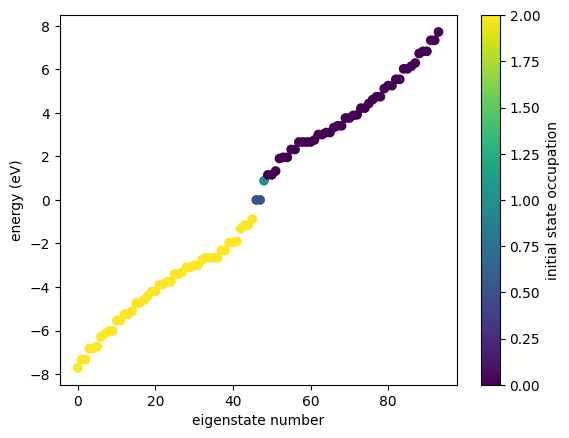

RHS compiled
RHS compiled


49.992928864375614 %


100.0 %


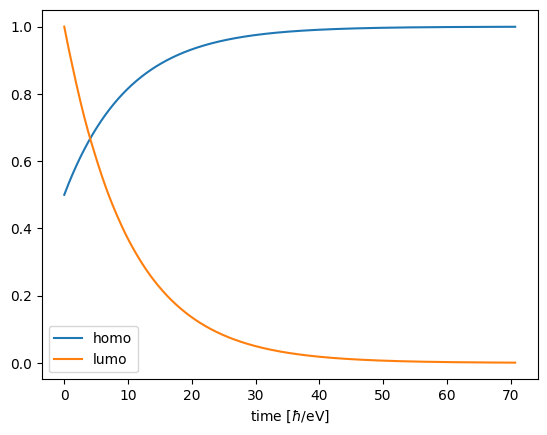

In [11]:
flake.set_excitation( flake.homo, flake.homo + 1, 1)
flake.show_energies()
result = flake.master_equation(
    relaxation_rate = 1/10,
    density_matrix = ["occ_e"],
    end_time = 40,
     )
flake.show_res(result, plot_only = [flake.homo, flake.homo+1], plot_labels = ["homo", "lumo"], show_illumination = False )

## Combinations

We can also extract multiple things at the same time

In [12]:
result = flake.master_equation(
    relaxation_rate = 1/10,
    density_matrix = ["full", "occ_x"],
    expectation_values = [flake.dipole_operator],
    end_time = 40,
    illumination = pulse,
)

RHS compiled
RHS compiled


49.992928864375614 %


100.0 %


The output will now contain three arrays: induced dipole moments, site occupations and full density matrices

In [13]:
print(len(result.output))
print(result.output[0].shape) # by default, operators come first
print(result.output[1].shape) # we specified ["full", "occ_x"] => full density matrices
print(result.output[2].shape) # we specified ["full", "occ_x"] => site occupations

3
(7072, 3)
(7072, 94, 94)
(7072, 94)


## Automatic Convergence Check

TBD

## Parameters

TBD